In [579]:
import pandas as pd
import json, random, os, re
import numpy as np
from zlib import crc32
from sklearn.metrics import roc_auc_score, precision_recall_curve, precision_score, recall_score, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
import yt.wrapper as yt
import catboost
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

yt.config["proxy"]["url"] = "hahn"
pd.options.mode.chained_assignment = None

In [5]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in xrange(size_x):
        matrix [x, 0] = x
    for y in xrange(size_y):
        matrix [0, y] = y

    for x in xrange(1, size_x):
        for y in xrange(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])/size_x
def str_to_float(b):
    return float(crc32(b) & 0xffffffff) / 2**32
def get_n_words(i):
    if isinstance(i, list):
        res = len(i)
    elif isinstance(i, dict):
        res = 0
        for k in i:
            res += get_n_words(i[k])
    else:
        res = i
    return res
def map_relevance(rel_string):
    rel_float = None
    if rel_string == "good":
        rel_float = 1.0
    elif rel_string == "part":
        rel_float = 0.3
    elif rel_string == "bad":
        rel_float = 0.0
    return rel_float
def get_label_easy(row):
    type_v1 = row['type']
    type_v2 = row['diff']
    if type_v1 == "diff":
        label = 1.0 if type_v2 != "same" else 0.0
    elif type_v1 == "same":
        label = 0.0
    else:
        label = None
    return label
def get_comp_star(row, weights, comp, dist=False):
    comps = ["{}_{}".format(comp, i) for i in weights]
    if dist:
        comps = (["{}_{}_dist".format(comp, i) for i in weights if i in pos_dict] +
                ["{}_{}".format(comp, i) for i in weights if i not in pos_dict])
    m = np.sum(row[comps]*weights.values())
    return m

In [7]:
def get_label_hard(row):
    type_v1 = row['type']
    type_v2 = row['diff']
    ref_answer = row['ref_answer'] or ''
    asr_answer = row['asr_answer'] or ''
    ref_action = row['ref_action'] or ''
    asr_action = row['asr_action'] or ''
    ref_scenario = row['ref_scenario']
    if type_v1 == "diff":
        label = 1.0 if type_v2 != "same" else 0.0
    elif type_v1 == "same":
        label = 0.0
    elif type_v1 == "hz":
        if ref_scenario == "alarm" or ref_scenario == "timer":
            r = re.compile('(\d|сегодня|завтра|".*")')
            if (re.sub(r, '', ref_answer) == re.sub(r, '', ref_answer)
                and len(re.findall(r, ref_answer)) == len(re.findall(r, asr_answer))):
                label = 0.0
            else:
                label = 1.0
        elif ref_scenario == "video":
            label = 1.0
            r = re.compile('".*"')
            ref_parts = re.findall(r, ref_action)
            asr_parts = re.findall(r, asr_action)
            if len(ref_parts) == len(asr_parts) and len(ref_parts) > 0:
                avg_ld = 0.0
                for i in range(len(ref_parts)):
                    avg_ld += levenshtein(ref_parts[i], asr_parts[i])
                avg_ld = avg_ld/len(ref_parts)
                if avg_ld < 0.7:
                    label = 0.0
        elif type_v2 == "same":
            label = 0.0
            if ref_scenario == "weather":
                r = re.compile('Сейчас в [^\s]* ')
                ref_parts = re.findall(r, ref_answer)
                asr_parts = re.findall(r, asr_answer)
                if (ref_parts and asr_parts and ref_parts[0] != asr_parts[0]) or len(ref_parts) != len(asr_parts):
                    label = 1.0
            elif ref_scenario == "translate" or ref_scenario == "find_poi":
                if ref_answer != asr_answer:
                    label = 1.0
            elif ref_scenario == "route":
                r = re.compile('Это путь до .*')
                ref_parts = re.findall(r, ref_answer)
                asr_parts = re.findall(r, asr_answer)
                if (ref_parts and asr_parts and ref_parts[0] != asr_parts[0]) or len(ref_parts) != len(asr_parts):
                    label = 1.0
            else:
                r = re.compile('^(К сожалению|Я не совсем поняла).*')
                if re.search(r, ref_answer) != re.search(r, asr_answer):
                    label = 1.0            
        elif type_v2 == "diff":
            label = 1.0
           
    else:
        label = None
    return label

In [ ]:
def make_pool(pool):
    simple_metrics = []
    infer_metrics = pool.metrics[0]
    for k in infer_metrics.keys():
        if not (isinstance(infer_metrics[k], dict) or isinstance(infer_metrics[k], list)):
            simple_metrics.append(k)   
    deriv_metrics = []
    
    for metric in simple_metrics:
        pool[metric] = pool.metrics.apply(lambda x: x[metric])
    for component in components:
        metric = component + "_words_len"
        name = component + "_avg_len"
        pool[name] = pool.metrics.apply(lambda x: np.mean(x[metric]))
        deriv_metrics.append(name)
        
        # add normed versions for _proper_nouns, _sense, _nonsense

        name = component + "_norm"
        pool[name] = pool.metrics.apply(lambda x: float(x[component])/x['N'])
        deriv_metrics.append(name)

        metric = component + "_POS"
        metric_norm = metric + "_norm"
        for pos in pos_dict:
            name = '{}_{}'. format(component, pos)
            pool[name] = pool.metrics.apply(lambda x: get_n_words({i: x[metric].get(i) for i in x[metric] if i in pos_dict[pos]}))
            deriv_metrics.append(name)
            name += "_norm"
            pool[name] = pool.metrics.apply(lambda x: get_n_words({i: x[metric].get(i) for i in x[metric] if i in pos_dict[pos]})/float(x['N']))
            deriv_metrics.append(name)
            if component == 'Sub':
                name = '{}_{}_dist'. format(component, pos)
                pool[name] = pool.metrics.apply(lambda x: np.mean([j for i in x[metric_norm] for j in x[metric_norm].get(i, np.nan) if i in pos_dict[pos]]))
                deriv_metrics.append(name)
                name = name + "_norm"
                pool[name] = pool.metrics.apply(lambda x: np.mean([j for i in x[metric_norm] for j in x[metric_norm].get(i, np.nan) if i in pos_dict[pos]])*x[component]/x['N'])
                deriv_metrics.append(name)
    pool['p'] = pool.req_id.apply(lambda x: str_to_float(str(x)))
    pool['random'] = np.random.rand(pool.shape[0])
    pool['ref_len'] = pool.ref_text.apply(lambda x: len(x))
    pool['asr_len'] = pool.asr_text.apply(lambda x: len(x))
    return pool, simple_metrics, deriv_metrics

In [ ]:
def make_cb_reg(pool, features, label='label'):
    X_train = pool[features]
    y_train = pool[label]
    clf = catboost.CatBoostRegressor(iterations=50, l2_leaf_reg=10.)
    clf.fit(X_train, y_train, verbose=False)
    return clf.score(X_train, y_train)
def make_lin_reg(pool, features, label='label'):
    X_train = pool[features].fillna(0)
    y_train = pool[label]
    reg = LinearRegression().fit(X_train, y_train)
    return reg.score(X_train, y_train)
def make_cb_clf(pool, features, label='label'):
    res = {}
    train = pool[(pool.p < 0.8) & (pool[label].isnull() == False)]
    test = pool[(pool.p >= 0.8) & (pool[label].isnull() == False)]
    X_train = train[features]
    X_test = test[features]
    y_train = train[label]
    y_test = test[label]
    iterations = min(X_train.shape[0]/X_train.shape[1], 500)
    clf = catboost.CatBoostClassifier(iterations=iterations, l2_leaf_reg=10.)
    clf.fit(X_train, y_train, verbose=False)
    res["auc_cb_test"] = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    res["iterations"] = iterations
    res["test"] = len(X_test)
    return res
def make_log_reg(pool, features, label='label'):
    res = {}
    train = pool[(pool.p < 0.8) & (pool[label].isnull() == False)]
    test = pool[(pool.p >= 0.8) & (pool[label].isnull() == False)]
    X_train = train[features]
    X_train = train[features].fillna(0)
    X_test = test[features].fillna(0)
    y_train = train[label]
    y_test = test[label]
    reg = LogisticRegression().fit(X_train, y_train)
    res["auc_reg_test"] = roc_auc_score(y_test, reg.predict_proba(X_test)[:, 1])
    return res
def calc_corr(pool, features):
    features += 'label'
    corr = pool[features].corr()
    return corr['label']
def get_coefs(pool, features, label='label'):
    train = pool[(pool.p < 0.8) & (pool[label].isnull() == False)]
    test = pool[(pool.p >= 0.8) & (pool[label].isnull() == False)]
    X_train = train[features].fillna(0)
    X_test = test[features].fillna(0)
    y_train = train[label]
    y_test = test[label]
    reg = LogisticRegression().fit(X_train, y_train)
    return dict(zip(features, reg.coef_[0]))

In [165]:
# 1) Dima's graph
# 2) Format and type https://yql.yandex-team.ru/Operations/XtlmPWim9YmO9CJiRrG4JwaCV6jicoZHSV5QwuZaJUo=
path = '//home/voice/nstbezz/wer/pool_5'
pool = yt.read_table(path, format='<encode_utf8=%false;missing_value_mode=print_sentinel;missing_value_sentinel=None>json')
pool = pd.DataFrame.from_records(pool)

In [266]:
# 1) Dima's graph https://nirvana.yandex-team.ru/flow/bb5efe7c-d3d0-40ed-897f-baf198892bb7/0b1d37a6-9952-4b5d-a549-3430d39c1902/graph/FlowchartBlockOperation/45a748a6-ada5-43aa-ba65-58c1825304bc
# 2) Format https://yql.yandex-team.ru/Operations/Xt6OGpdg8uFF8KhmyaMc_WflqGJ0bLO7Zp5GJ4wPkug=
path = '//home/voice/nstbezz/wer/pool_mer'
pool_mer = yt.read_table(path, format='<encode_utf8=%false;missing_value_mode=print_sentinel;missing_value_sentinel=None>json')
pool_mer = pd.DataFrame.from_records(pool_mer)

In [557]:
poses = ["INTJ", "PRT", "FOREIGN", "null", "NUMR", "VERB", "ADVB", "PRCL", "ADJ", "CONJ", "PREP", "GRND", "NPRO", "NOUN"] 
pos_dict = {
    "FOREIGN" : ["FOREIGN"], # латиница
    "MISC": ["NPRO", # местоимение-существительное (он)
             "PREP", # предлог (в)
             "CONJ", # союз (и)
             "INTJ", # междометие (ой)
             "PRCL", # частица (бы, же, лишь)
             "null"],
    "NOUN": ["NOUN"], # имя существительное (хомяк)
    "VERB": ["VERB"], # глагол (личная форма, инфинитив INFN) (говорю, говорит, говорил, говорить, сказать)
    "ADVB": ["ADVB", # наречие (круто), компаратив COMP (лучше, получше, выше), предикатив PRED (некогда)
             "GRND"], # деепричастие (прочитав, рассказывая)
    "ADJ": ["ADJ", # имя прилагательное (полное ADJF, краткое ADJS) (хороший, хорош)
            "PRT"], # причастие (полное PRTF, краткое PRTS) (прочитавший, прочитанная, прочитана)    
    "NUMR": ["NUMR"], # числительное (три, пятьдесят)
    "TOTAL": poses} # все граммемы
components = ['Del', 'Ins', 'Sub']

In [267]:
### Make pools

pool_mer, simple_metrics, deriv_metrics = make_pool(pool_mer)

pool, simple_metrics, deriv_metrics = make_pool(pool)
pool['label_hard'] = pool.apply(lambda x: get_label_hard(x), axis=1, result_type = 'reduce')
pool['label_easy'] = pool.apply(lambda x: get_label_easy(x), axis=1, result_type = 'reduce')

pool_mean = pool.groupby(by='num_of_text').mean()
pool_mean = pool_mean.reset_index()
path = '//home/voice/nstbezz/wer/data_names_2'
names = yt.read_table(path, format='<encode_utf8=%false;missing_value_mode=print_sentinel;missing_value_sentinel=None>json')
names = pd.DataFrame.from_records(names)
pool_mean["name"] = names["name"]

In [582]:
### Synth stats table

desc = ["name", "ref_len", "asr_len", "label_hard"]
bs = ["WER(basic)", "WER(norm_lemm)", 'MER-1.0(norm)']
t = pool_mean[desc + bs]
t["WER(basic)"] = t["WER(basic)"].apply(lambda x: 100*x)
t["MER-1.0(norm)"] = t["MER-1.0(norm)"].apply(lambda x: 100*x)
t[desc + bs].style.set_precision(2).background_gradient(cmap="YlOrRd", subset=pd.IndexSlice[:, ['label_hard'] + bs])

,name,ref_len,asr_len,label_hard,WER(basic),WER(norm_lemm),MER-1.0(norm)
0,Нет ухудшений,24,23,0.38,57,48,49
1,Транслит,20,20,0.52,45,46,50
2,Замена символа,20,20,0.24,45,45,50
3,Удаление,24,17,0.42,32,32,40
4,Удаление последнего,24,17,0.56,32,32,40
5,Замена,20,20,0.65,45,46,50
6,Склонение,21,22,0.36,44,3.3,47
7,Вставка,20,28,0.4,45,46,38
8,Перестановка,24,24,0.2,64,65,56
9,Перестановка подряд,24,24,0.18,64,64,53


/place/home/nstbezz/jupnb/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/place/home/nstbezz/jupnb/local/lib/python2.7/site-packages/seaborn/regression.py:424: UserWarning: Cannot set sticky_edges; requires newer matplotlib.
  warnings.warn(msg, UserWarning)
/place/home/nstbezz/jupnb/local/lib/python2.7/site-packages/seaborn/regression.py:424: UserWarning: Cannot set sticky_edges; requires newer matplotlib.
  warnings.warn(msg, UserWarning)
/place/home/nstbezz/jupnb/local/lib/python2.7/site-packages/seaborn/regression.py:424: UserWarning: Cannot set sticky_edges; requires newer matplotlib.
  warnings.warn(msg, UserWarning)
/place/home/n

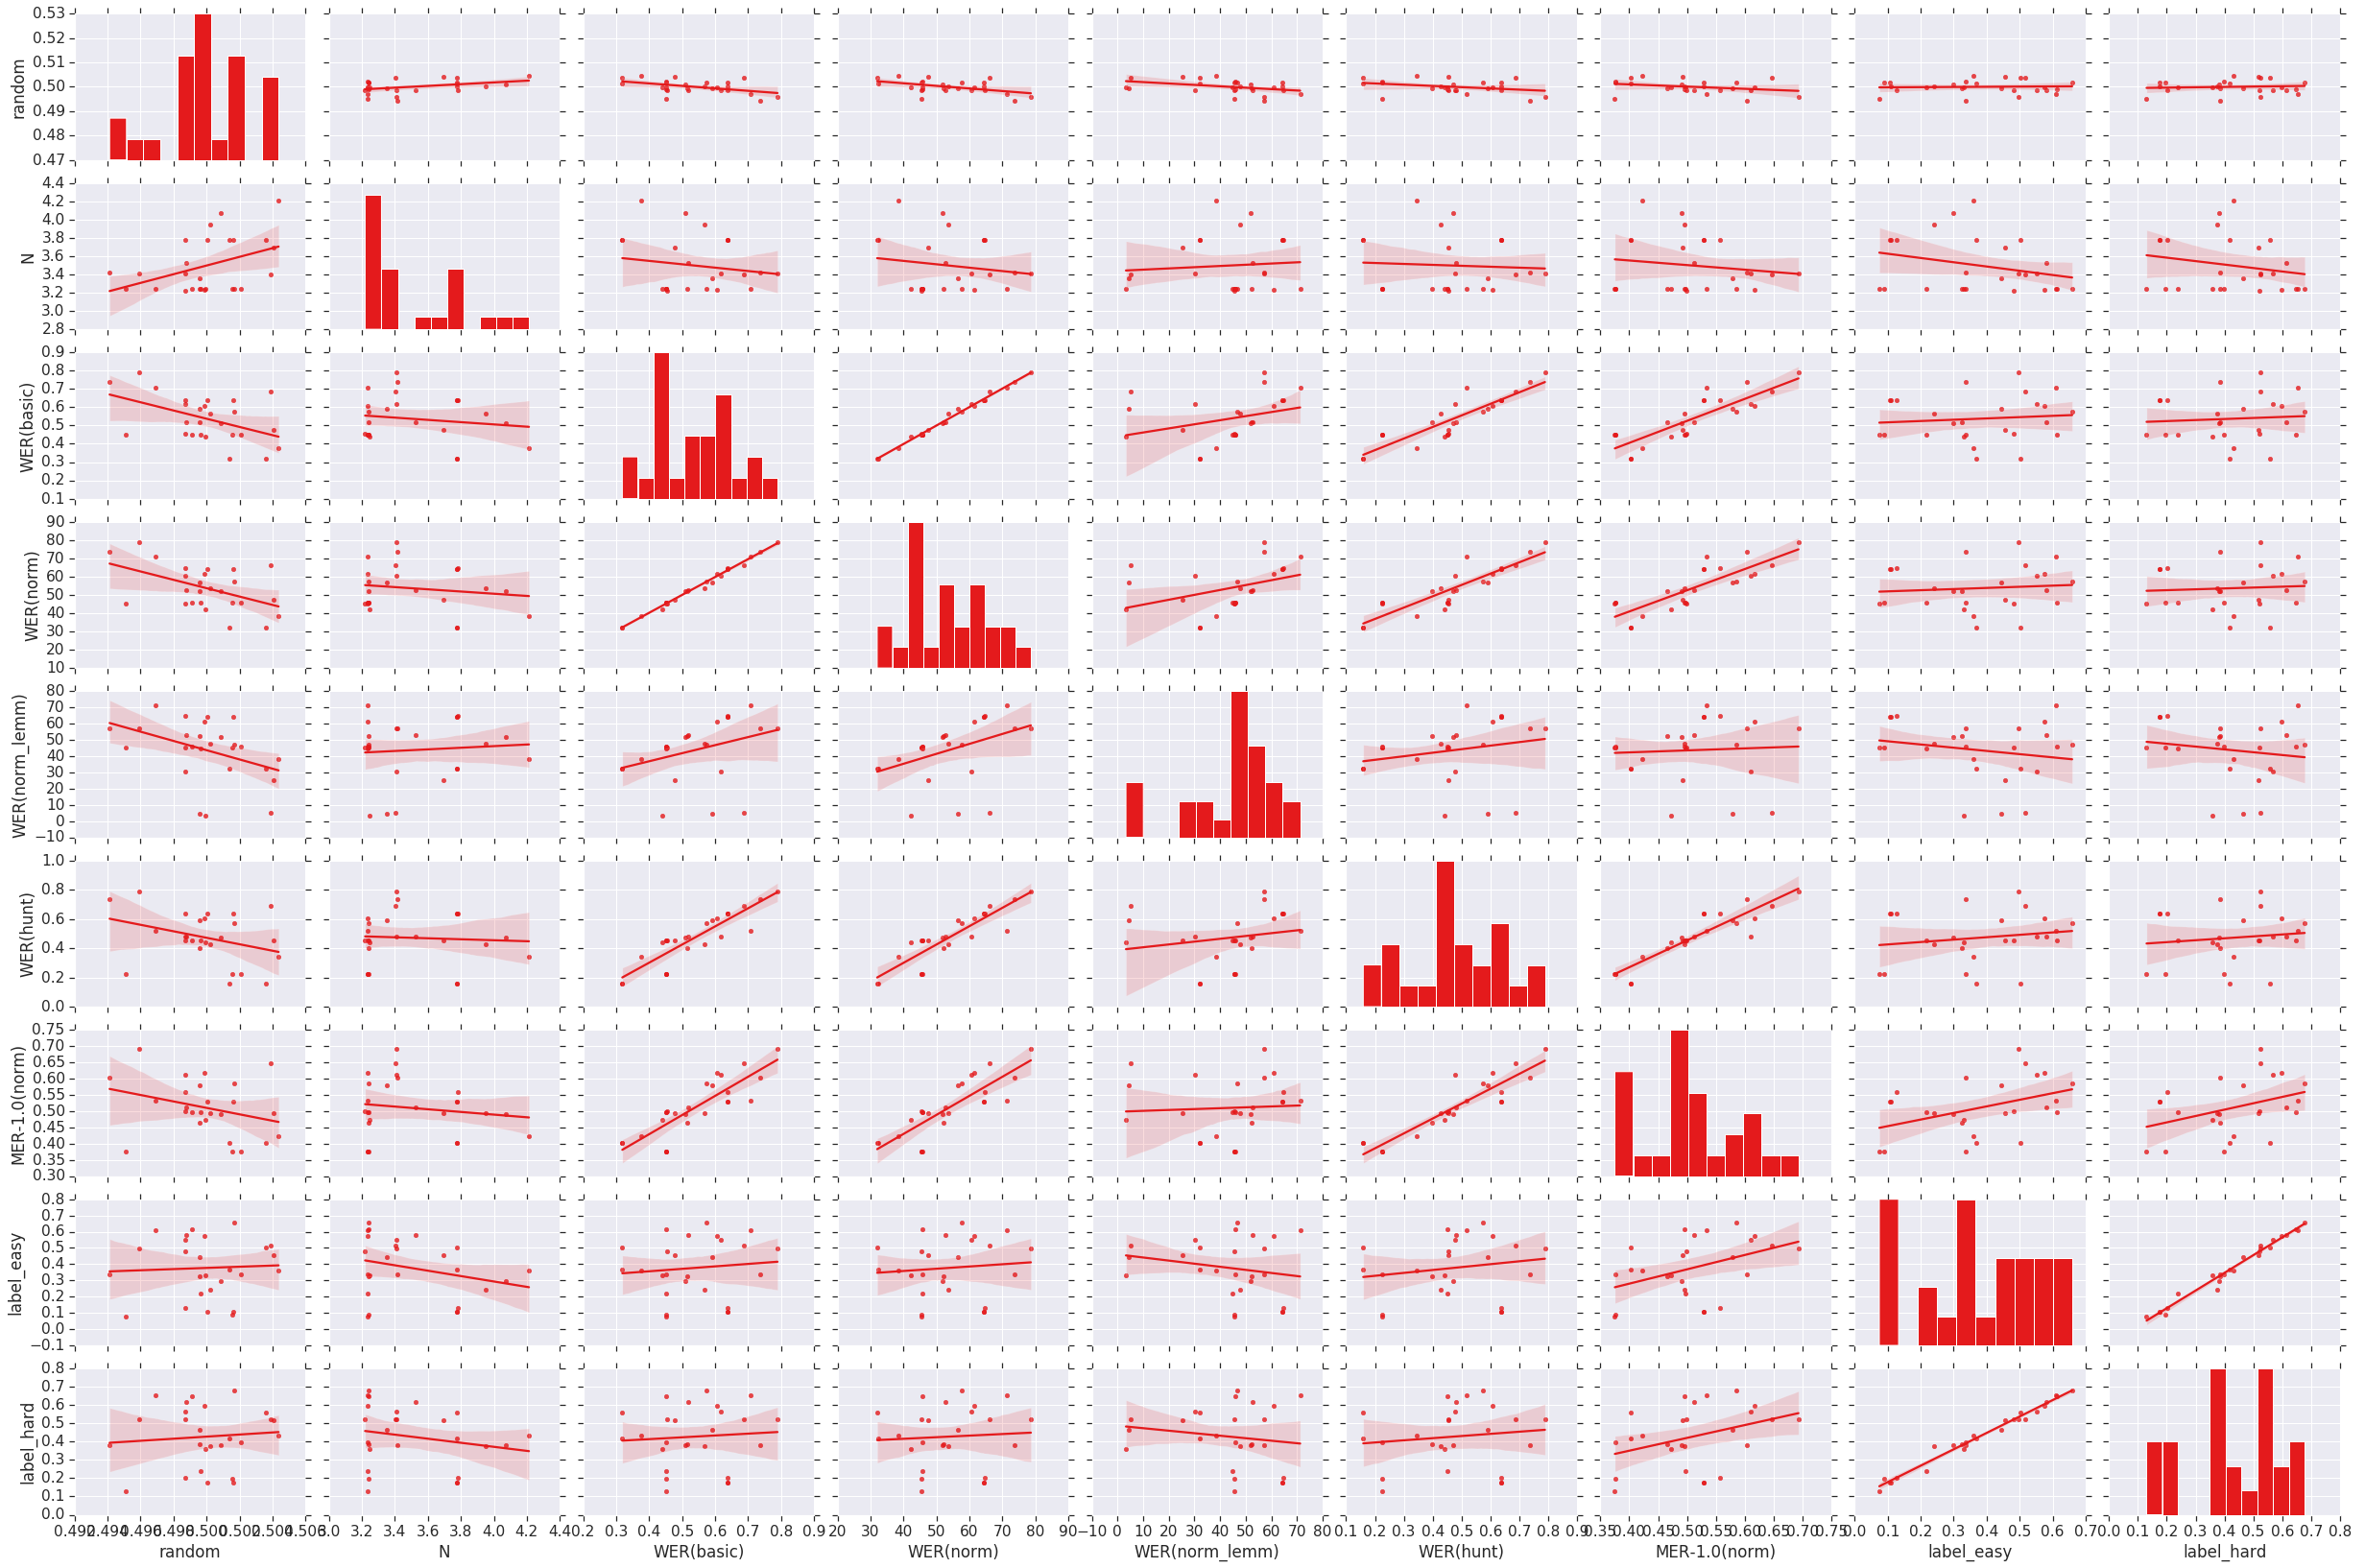

In [585]:
### Synth mean correlations

features = [j for i in baselines for j in i['features'] if i['group'] == 0]
labels = ['label_easy', 'label_hard']
sns.pairplot(pool_mean, vars=(features + labels), kind="reg", aspect=1.5)

#vs = ['N', 'WER(basic)', 'WER(norm)', 'WER(hunt)', 'MER-1.0(norm)', 'label_hard']
#sns.pairplot(pool_mean, vars=vs, kind="reg", aspect=1.5)

In [390]:
### Baselines

components = ['Del', 'Ins', 'Sub']
features = simple_metrics + deriv_metrics
baselines = [
    {"group": 0, "name": "rand", "features": ['random']},
    {"group": 0, "name": "n_words", "features": ['N']},
    {"group": 0, "name": "wer", "features": ['WER(basic)']},
    {"group": 0, "name": "wer_norm", "features": ['WER(norm)']},
    {"group": 0, "name": "wer_norm_lemm", "features": ['WER(norm_lemm)']},
    {"group": 0, "name": "wil", "features": ['WER(hunt)']},
    {"group": 0, "name": "mer", "features": ['MER-1.0(norm)']},
    {"group": 1, "name": "wer_comps_3", "features": [i + "_norm" for i in components]},
    {"group": 1, "name": "wer_comps_8", "features": [f for f in features if f.split("_")[0] in components and ('TOTAL_dist' in f or 'TOTAL_norm' in f or 'len' in f)]},
    {"group": 1, "name": "wer_comps_21", "features": [f for f in features if f.split("_")[0] in components and 'TOTAL' not in f and ('_dist_norm' in f or ('Sub' not in f and '_norm' in f and len(f.split("_")) >= 3))]},
    {"group": 1, "name": "wer_comps_30", "features": [f for f in features if f.split("_")[0] in components and 'TOTAL' not in f and ('_dist_norm' in f or 'sense' in f or 'proper' in f or ('Sub' not in f and '_norm' in f and len(f.split("_")) >= 3))]},
    {"group": 1, "name": "all", "features": simple_metrics + deriv_metrics}
]

In [271]:
### Baseline performance

pools = [
    {"name": "synthetic", "pool": pool, "labels": ['label_easy', 'label_hard']},
    {"name": "basket", "pool": pool[(pool.num_of_text == 0)], "labels": ['label_easy', 'label_hard']},
    {"name": "mer", "pool": pool_mer, "labels": ['label']}
]
# pool_mean = pool.groupby(by='num_of_text').mean()
for j, pool_j in enumerate(pools):
    for label in pool_j["labels"]:
        _label = label.replace('label', '')
        for i, baseline in enumerate(baselines):
            features = baseline['features']
            baseline['n_features'] = len(features)
            baseline['i'] = i
            if pool_j['name'] == "synthetic":
                baseline['r2_cb{}'.format(_label)] = make_cb_reg(pool_mean, features, label)
                baseline['r2_reg{}'.format(_label)] = make_lin_reg(pool_mean, features, label)
            res = make_cb_clf(pool_j["pool"], features, label)
            res.update(make_log_reg(pool_j["pool"], features, label))
            for r in res:
                baseline['{}_{}{}'.format(r, pool_j["name"], _label)] = res[r]
stats_df = pd.DataFrame.from_records(baselines)
# stats_df.to_pickle('stats_df') 
# stats_df = pd.read_pickle('stats_df')

In [ ]:
### R2 for synth pool means (a bit strange)

sns.set(rc={'figure.figsize':(10,8)}, style="darkgrid", palette="Set1", font_scale=1.4)
ax = stats_df.plot(kind='barh',x='name',y=['r2_reg_hard', 'r2_reg_easy'],
                   xlim=(0,1), title="R2, synthetic pool (group means)")
ax.set_ylabel("Linear")
ax = stats_df.plot(kind='barh',x='name',y=['r2_cb_hard', 'r2_cb_easy'],
                   xlim=(0,0.35), legend=False)
ax.set_ylabel("Catboost")

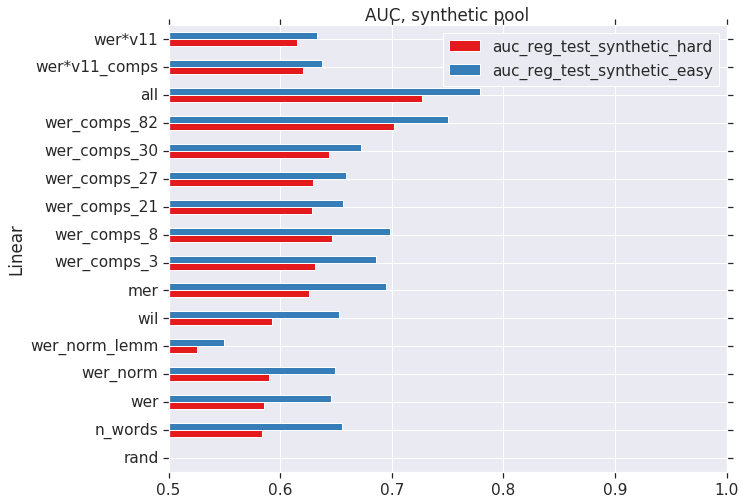

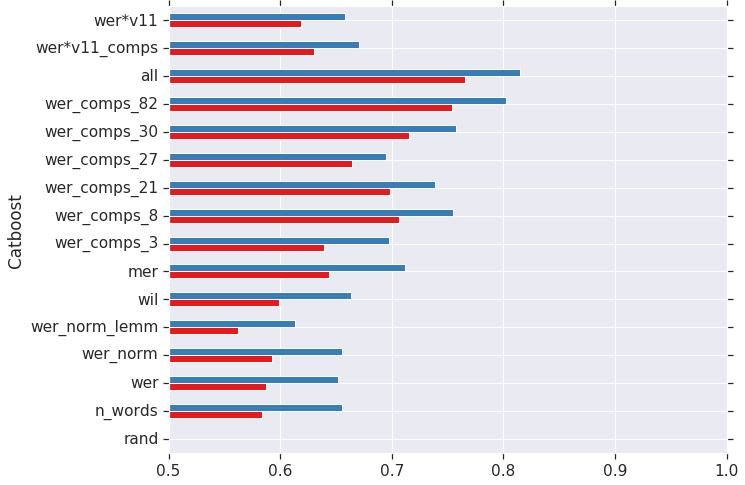

In [296]:
### AUCs for synthetic pool

ax = stats_df.plot(kind='barh',x='name',y=['auc_reg_test_synthetic_hard', 'auc_reg_test_synthetic_easy'],
                   xlim=(0.5,1), title="AUC, synthetic pool")
ax.set_ylabel("Linear")
ax = stats_df.plot(kind='barh',x='name',y=['auc_cb_test_synthetic_hard', 'auc_cb_test_synthetic_easy'],
                   xlim=(0.5,1), legend=False)
ax.set_ylabel("Catboost")

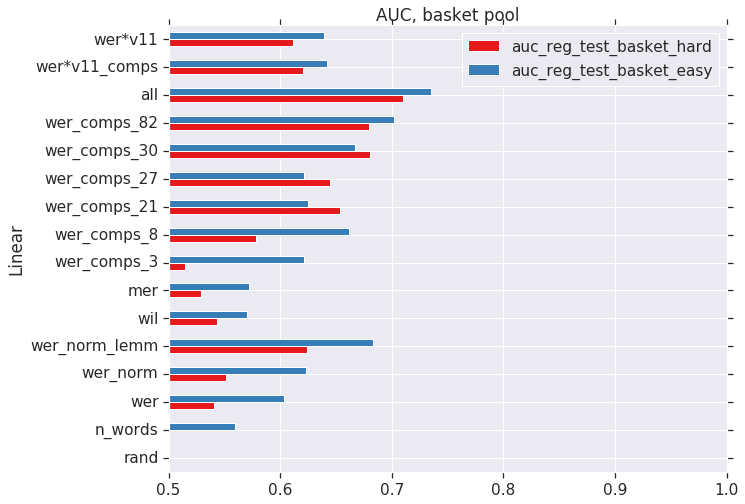

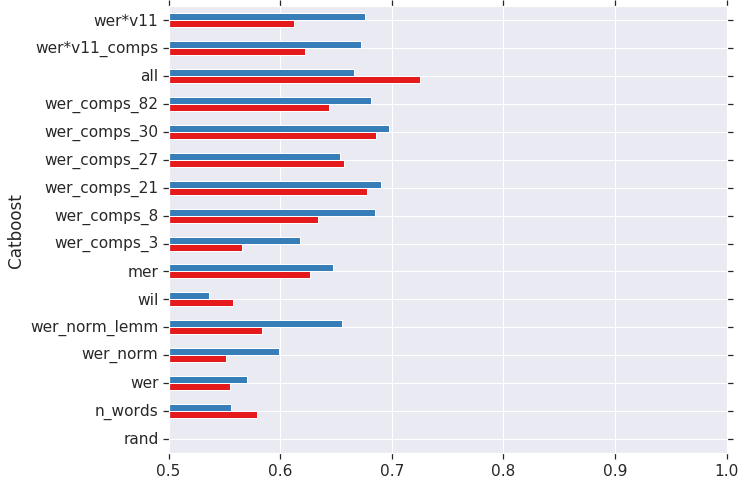

In [297]:
### AUCs for basket pool

ax = stats_df.plot(kind='barh',x='name',y=['auc_reg_test_basket_hard', 'auc_reg_test_basket_easy'],
                   xlim=(0.5,1), title="AUC, basket pool")
ax.set_ylabel("Linear")
ax = stats_df.plot(kind='barh',x='name',y=['auc_cb_test_basket_hard', 'auc_cb_test_basket_easy'],
                   xlim=(0.5,1), legend=False)
ax.set_ylabel("Catboost")

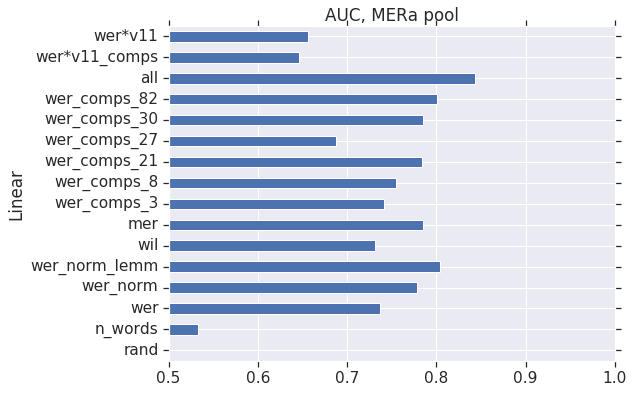

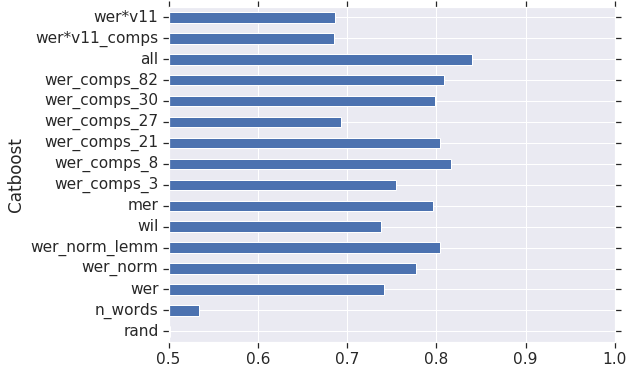

In [298]:
### AUCs for MERa pool

sns.set(rc={'figure.figsize':(8,6)}, style="darkgrid", font_scale=1.4)
ax = stats_df.plot(kind='barh',x='name',y=['auc_reg_test_mer'],
                   xlim=(0.5,1), title="AUC, MERa pool", legend=False)
ax.set_ylabel("Linear")
ax = stats_df.plot(kind='barh',x='name',y=['auc_cb_test_mer'],
                   xlim=(0.5,1), legend=False)
ax.set_ylabel("Catboost")

In [273]:
### Multiple regressions with component features

coef_baselines = [i for i in baselines if i['group'] == 1]
coef_df = []
pools = [
    {"name": "synthetic", "pool": pool, "labels": ['label_hard']},
    {"name": "basket", "pool": pool[(pool.num_of_text == 0)], "labels": ['label_hard']},
    {"name": "mer", "pool": pool_mer, "labels": ['label']}]
for j, pool_j in enumerate(pools):
    for label in pool_j["labels"]:
        _label = label.replace('label', '')
        for i, baseline in enumerate(coef_baselines):
            features = baseline['features']
            coefs = get_coefs(pool_j["pool"], features, label)
            coefs = [{"name": k, "value": v, "pool": pool_j["name"], "label": label} for k, v in coefs.items()]
            coef_df += coefs
coef_df = pd.DataFrame.from_records(coef_df)
coef_df['component'] = coef_df.name.apply(lambda x: x.split('_')[0] if x.split('_')[0] in components else None)
coef_df['pos'] = coef_df.name.apply(lambda x: x.split('_')[1] if len(x.split('_')) > 1 and x.split('_')[1] in pos_dict.keys() else None)
# coef_df.to_pickle('coef_df') 
# coef_df = pd.read_pickle('coef_df')
tmp = pd.pivot_table(coef_df, index=['component', 'pos'],columns=['pool'],values='value',
                    aggfunc={'value': [np.mean, len]}).reset_index() #default: np.mean
tmp.columns = [' '.join(col).strip() for col in tmp.columns.values]

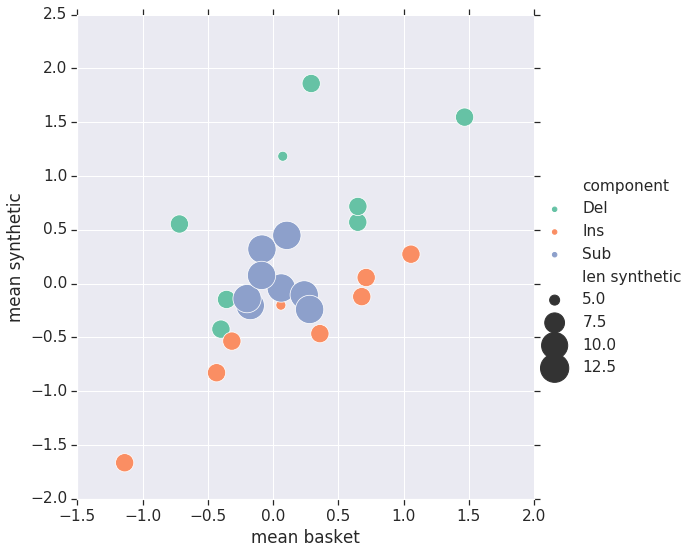

In [276]:
sns.set(rc={'figure.figsize':(8,6)}, style="darkgrid", palette="Set2", font_scale=1.4)
sns.relplot(x='mean basket', y='mean synthetic', data=tmp, hue='component', size='len synthetic',
            sizes=(100, 800), height=8)
sns.relplot(x='mean basket', y='mean synthetic', data=tmp, hue='pos', size='len synthetic',
            sizes=(100, 800), height=8)

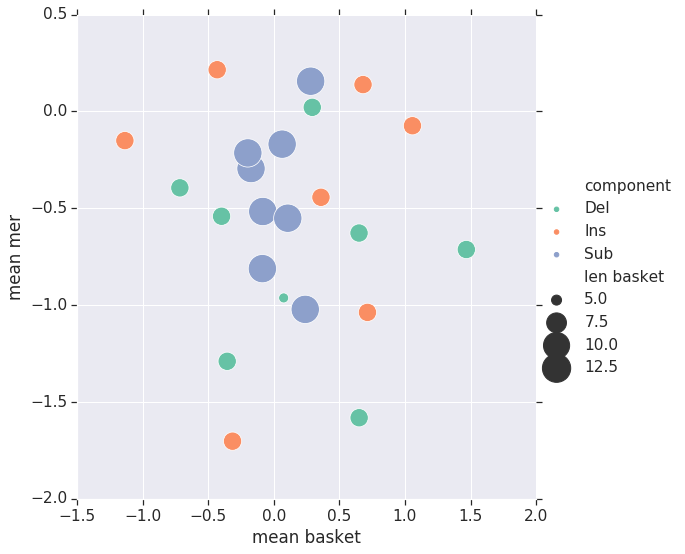

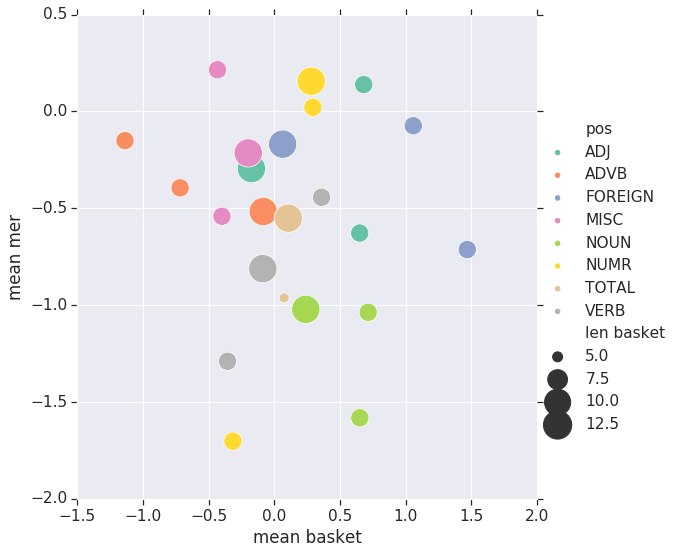

In [279]:
sns.relplot(x='mean basket', y='mean mer', data=tmp, hue='component', size='len basket',
            sizes=(100, 800), height=8)
sns.relplot(x='mean basket', y='mean mer', data=tmp, hue='pos', size='len basket',
            sizes=(100, 800), height=8)

In [352]:
### Select best components, calc coefs on two pools

features = simple_metrics + deriv_metrics
features = [f for f in features if f.split("_")[0] in components and 'TOTAL' not in f and ('nonsense' in f or ('_norm' in f and len(f.split("_")) == 3))]
coef_baselines = [{"group": 0, "name": "wer*v00", "features": features}]
coef_df = []
pools = [
    {"name": "synthetic", "pool": pool, "labels": ['label_hard']},
    {"name": "basket", "pool": pool[(pool.num_of_text == 0)], "labels": ['label_hard']}]

for j, pool_j in enumerate(pools):
    for label in pool_j["labels"]:
        _label = label.replace('label', '')
        for i, baseline in enumerate(coef_baselines):
            features = baseline['features']
            coefs = get_coefs(pool_j["pool"], features, label)
            coefs = [{"name": k, "value": v, "pool": pool_j["name"], "label": label} for k, v in coefs.items()]
            coef_df += coefs
coef_df = pd.DataFrame.from_records(coef_df)
coef_df['component'] = coef_df.name.apply(lambda x: x.split('_')[0] if x.split('_')[0] in components else None)
coef_df['pos'] = coef_df.name.apply(lambda x: x.split('_')[1] if len(x.split('_')) > 1 and x.split('_')[1] in (pos_dict.keys() + ['nonsense'] ) else None)
tmp = pd.pivot_table(coef_df, index=['component', 'pos'],columns=['pool'],values='value', aggfunc={'value': [np.mean, len]}).reset_index()
tmp.columns = [' '.join(col).strip() for col in tmp.columns.values]

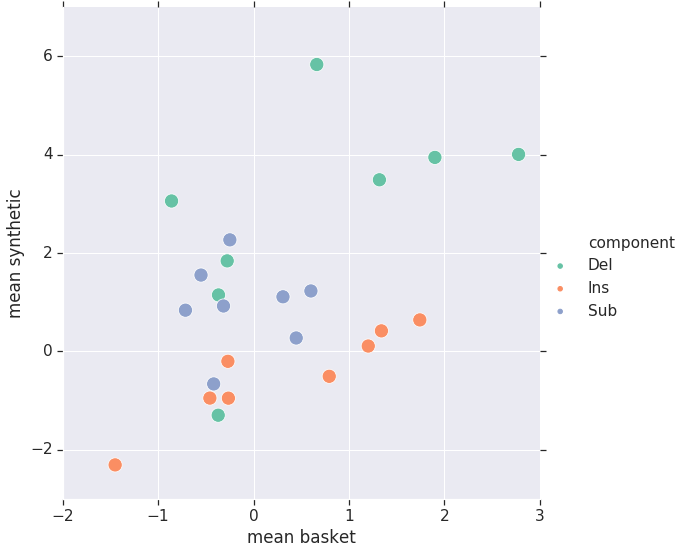

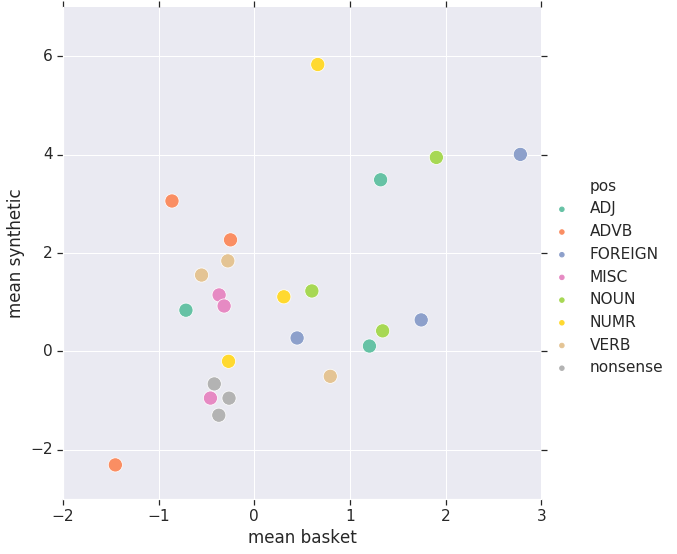

In [353]:
sns.set(rc={'figure.figsize':(8,6)}, style="darkgrid", palette="Set2", font_scale=1.4)
sns.relplot(x='mean basket', y='mean synthetic', data=tmp, hue='component', s=200, height=8)
sns.relplot(x='mean basket', y='mean synthetic', data=tmp, hue='pos', s=200, height=8)

In [325]:
### WER*v00

label = 'label_hard'
pool_j = pool[pool.num_of_text == 0]
train = pool_j[(pool_j.p < 0.8) & (pool_j[label].isnull() == False)]
test = pool_j[(pool_j.p >= 0.8) & (pool_j[label].isnull() == False)]
X_train = train[features].fillna(0)
X_test = test[features].fillna(0)
y_train = train[label]
y_test = test[label]

reg = LogisticRegression().fit(X_train, y_train)
print 'auc train: {:.3f}'.format(roc_auc_score(y_train, reg.predict_proba(X_train)[:, 1]))
print 'auc test: {:.3f}'.format(roc_auc_score(y_test, reg.predict_proba(X_test)[:, 1]))
for k, v in sorted(dict(zip(features, reg.coef_[0])).items(), key=lambda kv: -kv[1]):
    print '{}\t{}'.format(k, v)
print reg.intercept_

auc train: 0.680
auc test: 0.666
Del_FOREIGN_norm	2.83439241067
Del_NOUN_norm	1.88023249793
Ins_FOREIGN_norm	1.77890924125
Del_ADJ_norm	1.36361702772
Ins_NOUN_norm	1.36025226707
Ins_ADJ_norm	1.1506693541
Ins_VERB_norm	0.800850871871
Del_NUMR_norm	0.687457985016
Sub_NOUN_norm	0.637812100364
Sub_FOREIGN_norm	0.526909988096
Sub_NUMR_norm	0.336796030208
Ins_NUMR_norm	-0.227424941495
Sub_ADVB_norm	-0.250739809409
Del_VERB_norm	-0.332605940284
Sub_MISC_norm	-0.46023558417
Sub_VERB_norm	-0.500534714281
Ins_MISC_norm	-0.545289928769
Del_MISC_norm	-0.610398390413
Sub_ADJ_norm	-0.671465160252
Del_ADVB_norm	-0.915935447493
Ins_ADVB_norm	-1.49468144889
[-0.68046724]


In [ ]:
reg_coef = reg.coef_[0]
features = simple_metrics + deriv_metrics
features = [f for f in features if f.split("_")[0] in components and 'TOTAL' not in f and ('nonsense' in f or ('_norm' in f and len(f.split("_")) == 3))]
name = 'WER*v00'
weight_dict = dict(zip(features, reg_coef))
metrics = weight_dict.keys()
weights = weight_dict.values()
pool[name] = pool.apply(lambda x: np.sum(x[metrics]*weights), axis=1, result_type = 'reduce')

for k, v in sorted(dict(zip(features, reg_coef)).items(), key=lambda kv: -kv[1]):
    k = k.strip('_norm')
    print '{}\t{:>.2f}'.format(k, v)

In [ ]:
### WER*v11

robust_coef_dict = {
    "Del_NUMR": 4.50,
    "Del_NOUN": 2.50,
    "Del_FOREIGN": 2.50,
    "Del_ADJ": 2.50,
    "Del_proper_nouns": 1.00,
    "Ins_FOREIGN": 1.00,
    "Ins_NOUN": 1.00,
    "Sub_VERB": 1.00,
    "Del_VERB": 1.00,
    "Sub_NUMR": 1.00,
    "Sub_sense": 1.00,
    "Sub_proper_nouns": 1.00,
    "Sub_NOUN": 1.00,
    "Ins_proper_nouns": 1.00,
    "Del_sense": 1.00,
    "Ins_sense": 1.00,
    "Sub_nonsense": -1.00,
    "Ins_nonsense": -1.00,
    "Del_nonsense": -1.00
}
name = 'WER*v11'
metrics = robust_coef_dict.keys()
weights = robust_coef_dict.values()
pool[name] = pool.apply(lambda x: np.sum(x[metrics]*weights)/float(x['N']), axis=1, result_type = 'reduce')

for k, v in sorted(robust_coef_dict.items(), key=lambda kv: -kv[1]):
    print '{}\t{:>.2f}'.format(k, v)

In [ ]:
### Repeat mean pool stats
desc = ["name", "ref_len", "asr_len", "label_hard"]
bs = ["WER(basic)", "WER(norm_lemm)", 'MER-1.0(norm)', "WER*v00", "WER*v11"]
t = pool_mean[desc + bs]
t["WER(basic)"] = t["WER(basic)"].apply(lambda x: 100*x)
t["MER-1.0(norm)"] = t["MER-1.0(norm)"].apply(lambda x: 100*x)
t["WER*v00"] = t["WER*v00"].apply(lambda x: 100*x + 10)
t["WER*v11"] = t["WER*v11"].apply(lambda x: 100*x)
t[desc + bs].style.set_precision(2).background_gradient(cmap="YlOrRd", subset=pd.IndexSlice[:, ['label_hard'] + bs])

In [ ]:
### Baselines with new WERs
components = ['Del', 'Ins', 'Sub']
features = simple_metrics + deriv_metrics
baselines = [
    {"group": 0, "name": "rand", "features": ['random']},
    {"group": 0, "name": "n_words", "features": ['N']},
    {"group": 0, "name": "wer", "features": ['WER(basic)']},
    {"group": 0, "name": "wer_norm", "features": ['WER(norm)']},
    {"group": 0, "name": "wer_norm_lemm", "features": ['WER(norm_lemm)']},
    {"group": 0, "name": "wil", "features": ['WER(hunt)']},
    {"group": 0, "name": "mer", "features": ['MER-1.0(norm)']},
    {"group": 1, "name": "wer_comps_3", "features": [i + "_norm" for i in components]},
    {"group": 1, "name": "wer_comps_8", "features": [f for f in features if f.split("_")[0] in components and ('TOTAL_dist' in f or 'TOTAL_norm' in f or 'len' in f)]},
    {"group": 1, "name": "wer_comps_21", "features": [f for f in features if f.split("_")[0] in components and 'TOTAL' not in f and ('_dist_norm' in f or ('Sub' not in f and '_norm' in f and len(f.split("_")) >= 3))]},
    {"group": 1, "name": "wer_comps_30", "features": [f for f in features if f.split("_")[0] in components and 'TOTAL' not in f and ('_dist_norm' in f or 'sense' in f or 'proper' in f or ('Sub' not in f and '_norm' in f and len(f.split("_")) >= 3))]},
    {"group": 1, "name": "all", "features": simple_metrics + deriv_metrics},
    {"group": 2, "name": "wer*v00", "features": ['WER*v00']},
    {"group": 2, "name": "wer*v11", "features": ['WER*v11']}
]

In [ ]:
### Baseline performance
pools = [
    {"name": "synthetic", "pool": pool, "labels": ['label_hard']},
    {"name": "basket", "pool": pool[(pool.num_of_text == 0)], "labels": ['label_hard']}
]
pool_mean = pool.groupby(by='num_of_text').mean()
for j, pool_j in enumerate(pools):
    for label in pool_j["labels"]:
        _label = label.replace('label', '')
        for i, baseline in enumerate(baselines):
            features = baseline['features']
            baseline['n_features'] = len(features)
            baseline['i'] = i
            if pool_j['name'] == "synthetic":
                baseline['r2_cb{}'.format(_label)] = make_cb_reg(pool_mean, features, label)
                baseline['r2_reg{}'.format(_label)] = make_lin_reg(pool_mean, features, label)
            res = make_cb_clf(pool_j["pool"], features, label)
            res.update(make_log_reg(pool_j["pool"], features, label))
            for r in res:
                baseline['{}_{}{}'.format(r, pool_j["name"], _label)] = res[r]

In [ ]:
sns.set(rc={'figure.figsize':(10,8)}, style="darkgrid", palette="Set2", font_scale=1.4)
ax = stats_df.plot(kind='barh',x='name',y=['r2_reg_hard', 'r2_cb_hard'],
                   xlim=(0,1), title="R2, synthetic pool (group means)")
ax = stats_df.plot(kind='barh',x='name',y=['auc_reg_test_synthetic_hard', 'auc_cb_test_synthetic_hard'],
                   xlim=(0.5,1), title="AUC, synthetic pool")
ax = stats_df.plot(kind='barh',x='name',y=['auc_reg_test_basket_hard', 'auc_cb_test_basket_hard'],
                   xlim=(0.5,1), title="AUC, basket pool")

In [ ]:
# MISC
X = sm.add_constant(X_train)
est = sm.Logit(y_train, X).fit()
print(est.summary())

corr = pool_mean.corr()
corr.style.background_gradient(cmap='RdYlGn').set_precision(1).hide_columns([])